In [ ]:
#### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install keras

In [1]:
import json
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from glob import glob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import re
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


                                                text  label  \
0  thi facebook post confus direct incom tax ever...      0   
1  we analyz theoret electron properti aharonov b...      0   
2  the possibl fli spacecraft close sun topic con...      1   
3  i think preclud possibl certain group peopl co...      0   
4  how studi test without cram studi test daunt e...      1   

                                              prompt   source    model  \
0  i ask question for question provid 200 word an...   reddit    human   
1  gener 150 220 word abstract work titl aharonov...    arxiv    human   
2  i ask question for question provid 200 word an...   reddit  chatGPT   
3  i ask question for question provid 200 word an...   reddit    human   
4  gener wikihow articl minimum 200 word titl how...  wikihow   cohere   

  dataset  pure  
0      M4     1  
1      M4     1  
2      M4     1  
3      M4     1  
4      M4     1  
45000


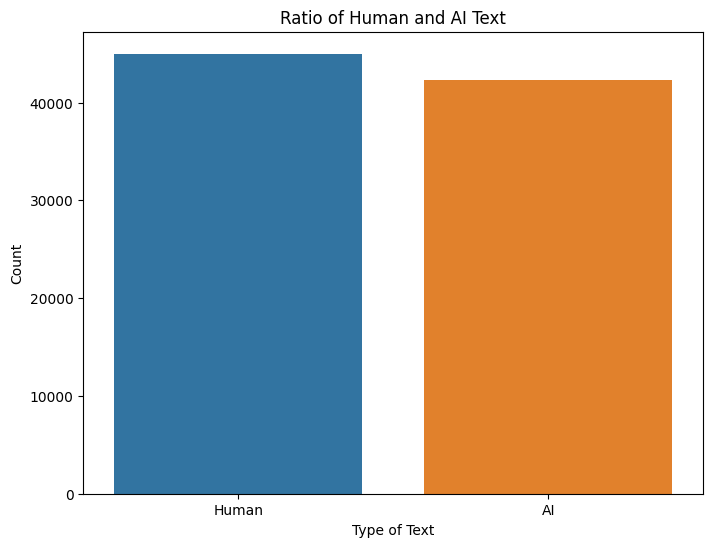

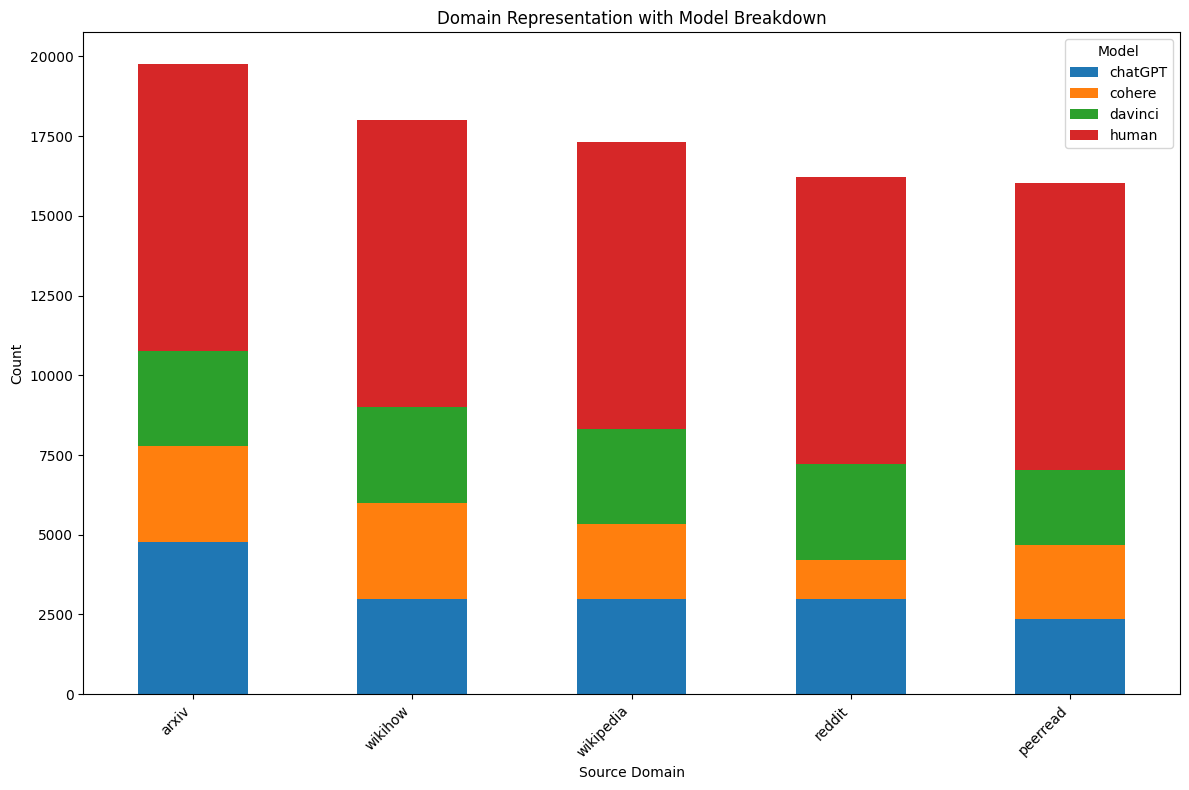

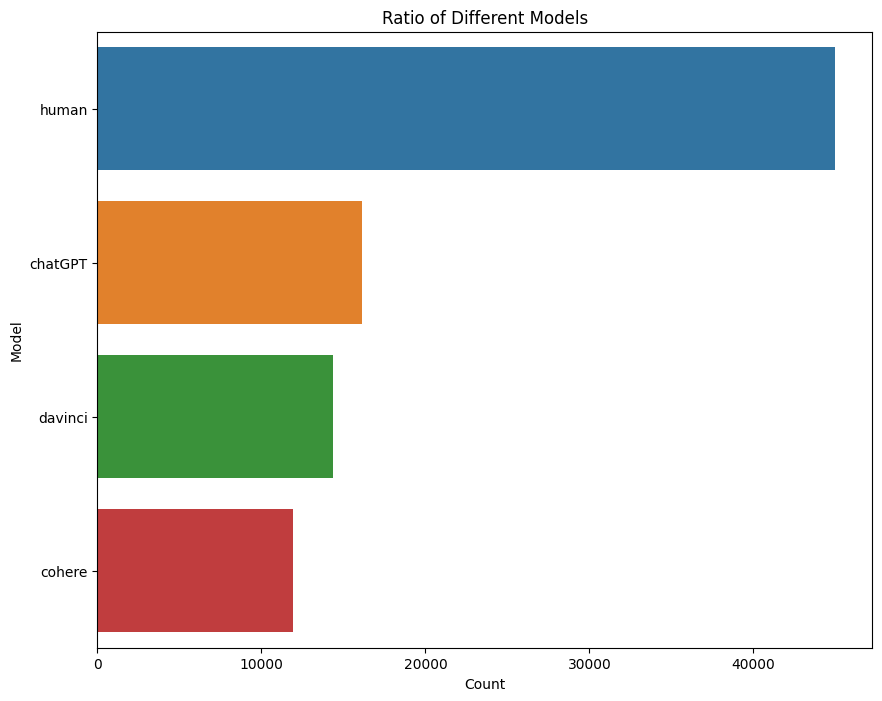

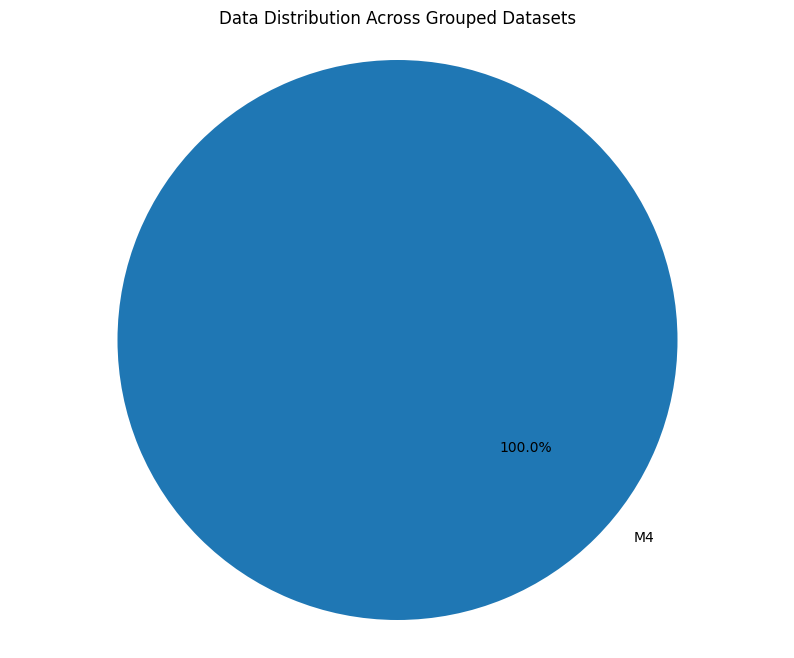

       source    model  count
0       arxiv  chatGPT   4769
1       arxiv   cohere   3000
2       arxiv  davinci   3000
3       arxiv    human   9000
4    peerread  chatGPT   2344
5    peerread   cohere   2344
6    peerread  davinci   2344
7    peerread    human   9000
8      reddit  chatGPT   3000
9      reddit   cohere   1220
10     reddit  davinci   3000
11     reddit    human   9000
12    wikihow  chatGPT   3000
13    wikihow   cohere   2999
14    wikihow  davinci   3000
15    wikihow    human   9000
16  wikipedia  chatGPT   2995
17  wikipedia   cohere   2336
18  wikipedia  davinci   3000
19  wikipedia    human   9000


In [3]:
# Load the datasets
train = pd.read_csv('/kaggle/input/m4-dataset/train_balanced.csv')
val = pd.read_csv('/kaggle/input/m4-dataset/val_balanced.csv')
test = pd.read_csv('/kaggle/input/m4-dataset/test_balanced.csv')

test_MGTBench = pd.read_csv('/kaggle/input/m4-dataset/test_MGTBench.csv')
test_MixSet = pd.read_csv('/kaggle/input/m4-dataset/test_MixSet.csv')

# Remove rows where the 'text' column is NaN from train, val, and test datasets
train = train.dropna(subset=['text'])
val = val.dropna(subset=['text'])
test = test.dropna(subset=['text'])
test_MGTBench = test_MGTBench.dropna(subset=['text'])
test_MixSet = test_MixSet.dropna(subset=['text'])

# You may want to reset the index after dropping rows
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)
test_MGTBench = test_MGTBench.reset_index(drop=True)
test_MixSet = test_MixSet.reset_index(drop=True)


# Combine the datasets for overall statistics
all_data = pd.concat([train, val, test], ignore_index=True)
print(all_data.head())
print(all_data[all_data['label'] == 0].shape[0])
# 1. Ratio of human and AI text
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=all_data)
plt.title('Ratio of Human and AI Text')
plt.xticks([0, 1], ['Human', 'AI'])
plt.xlabel('Type of Text')
plt.ylabel('Count')
plt.show()

# 2. Ratio of different domain sources
# Group the data by 'source' and 'model' and get the size of each group
model_domain_counts = all_data.groupby(['source', 'model']).size().unstack(fill_value=0)

# Calculate total counts for each domain by summing across models
total_counts_by_domain = model_domain_counts.sum(axis=1)

# Sort domains by total counts in descending order
sorted_domains = total_counts_by_domain.sort_values(ascending=False).index

# Reindex the DataFrame to reflect this order
model_domain_counts_sorted = model_domain_counts.reindex(sorted_domains)

# Now plot the sorted DataFrame
model_domain_counts_sorted.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Domain Representation with Model Breakdown')
plt.xlabel('Source Domain')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate domain names for better readability
plt.legend(title='Model')

plt.tight_layout()  # Adjust layout to make room for the rotated domain names
plt.show()

# 3. Ratio of different models
plt.figure(figsize=(10, 8))
sns.countplot(y='model', data=all_data, order = all_data['model'].value_counts().index)
plt.title('Ratio of Different Models')
plt.xlabel('Count')
plt.ylabel('Model')
plt.show()

# 4. Show the dataset distribution
# Preprocess 'dataset' column to group all "Mixset" related data under a single category "Mixset"
all_data['dataset_grouped'] = all_data['dataset'].apply(lambda x: 'Mixset' if 'Mixset' in x else x)

# Aggregate data by the newly created 'dataset_grouped'
dataset_distribution_grouped = all_data['dataset_grouped'].value_counts()

# Plot pie chart for the grouped dataset distribution
plt.figure(figsize=(10, 8))
plt.pie(dataset_distribution_grouped, labels=dataset_distribution_grouped.index, autopct='%1.1f%%', startangle=140)
plt.title('Data Distribution Across Grouped Datasets')
plt.axis('equal')  # Ensures the pie chart is circular
plt.show()

# Print the number of entries for each model within each domain
model_domain_counts = all_data.groupby(['source', 'model']).size().reset_index(name='count')
print(model_domain_counts)


In [4]:
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer
from collections import Counter
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import SubsetRandomSampler
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import numpy as np

max_words = 10000  # Number of words to consider from the texts
max_len = 200  # Max length of each sequence

# Define tokenizer
tokenizer = get_tokenizer('basic_english')

# Function to yield tokens; needed for building the vocabulary
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

# Load datasets
train = pd.read_csv('/kaggle/input/m4-dataset/train_balanced.csv', dtype={'text': str, 'label': str})
val = pd.read_csv('/kaggle/input/m4-dataset/val_balanced.csv', dtype={'text': str, 'label': str})
test = pd.read_csv('/kaggle/input/m4-dataset/test_balanced.csv', dtype={'text': str, 'label': str})
test_MGTBench = pd.read_csv('/kaggle/input/m4-dataset/test_MGTBench.csv', dtype={'text': str, 'label': str})
test_MixSet = pd.read_csv('/kaggle/input/m4-dataset/test_MixSet.csv', dtype={'text': str, 'label': str})

# Combine all texts to build the vocabulary
all_texts = pd.concat([train['text'], val['text'], test['text']]).dropna().values

# Vocabulary building with size limit
counter = Counter(token for text in all_texts for token in tokenizer(text))
vocab = {token: idx + 2 for idx, (token, count) in enumerate(counter.most_common(max_words - 2))}
vocab['<pad>'] = 0
vocab['<unk>'] = 1

# Function for encoding texts
def encode_texts(texts, vocab, max_len):
    encoded_texts = []
    for text in texts:
        encoded_text = [vocab.get(token, vocab['<unk>']) for token in tokenizer(text)]
        # Padding and truncating
        encoded_text = encoded_text[:max_len] + [vocab['<pad>']] * max(0, max_len - len(encoded_text))
        encoded_texts.append(torch.tensor(encoded_text))
    return pad_sequence(encoded_texts, batch_first=True)

# Function for encoding labels
def encode_labels(labels):
    le = LabelEncoder()
    return torch.tensor(le.fit_transform(labels), dtype=torch.long)

# Encode all datasets
X_train, y_train = encode_texts(train['text'].astype(str).values, vocab, max_len), encode_labels(train['label'].values)
X_val, y_val = encode_texts(val['text'].astype(str).values, vocab, max_len), encode_labels(val['label'].values)
X_test, y_test = encode_texts(test['text'].astype(str).values, vocab, max_len), encode_labels(test['label'].values)
X_test_MGTBench, y_test_MGTBench = encode_texts(test_MGTBench['text'].astype(str).values, vocab, max_len), encode_labels(test_MGTBench['label'].values)
X_test_MixSet, y_test_MixSet = encode_texts(test_MixSet['text'].astype(str).values, vocab, max_len), encode_labels(test_MixSet['label'].values)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute class weights
labels_unique, counts = np.unique(y_train, return_counts=True)
class_weights = compute_class_weight(class_weight='balanced', classes=labels_unique, y=y_train.cpu().numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Convert datasets to DataLoader
batch_size = 32
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size)
test_data_MGTBench = TensorDataset(X_test_MGTBench, y_test_MGTBench)
test_loader_MGTBench = DataLoader(test_data_MGTBench, batch_size=batch_size)
test_data_MixSet = TensorDataset(X_test_MixSet, y_test_MixSet)
test_loader_MixSet = DataLoader(test_data_MixSet, batch_size=batch_size)

# Print dataset sizes for confirmation
print(f"Train dataset size: {len(train_data)}")
print(f"Validation dataset size: {len(val_data)}")
print(f"Test dataset size: {len(test_data)}")

Train dataset size: 53478
Validation dataset size: 17826
Test dataset size: 17827


In [7]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F

# LSTM with Attention model
# Define an attention mechanism
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, lstm_output):
        # lstm_output shape: (batch_size, seq_length, hidden_size)
        attention_weights = self.attention(lstm_output).squeeze(2)
        attention_weights = F.softmax(attention_weights, dim=1).unsqueeze(2)
        # attention_weights shape: (batch_size, seq_length, 1)

        # apply attention weights
        attended = attention_weights * lstm_output
        # sum over seq_length
        attended = attended.sum(1) 
        return attended, attention_weights

class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bilstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.bilstm(x)
        x = self.dropout(x)
        # Use the last hidden state of BiLSTM for classification
        x = x[:, -1, :]
        x = self.fc(x)
        return x

class CNNBiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, num_classes, kernel_sizes, num_filters):
        super(CNNBiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList(
            [nn.Conv1d(embedding_dim, num_filters, kernel_size, padding=kernel_size//2) for kernel_size in kernel_sizes]
        )
        # Ensure the LSTM input size matches the total number of convolutional filters
        self.bilstm = nn.LSTM(num_filters * len(kernel_sizes), hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(1, 2)  # Change the shape to [batch, embedding_dim, seq_length]
        
        # Apply convolutions and concatenate
        conv_outputs = [F.relu(conv(x)) for conv in self.convs]
        x = torch.cat(conv_outputs, 1)  # Concatenate along the filter dimension
        
        # Ensure the output is [batch, seq_length, total_filters]
        x = x.permute(0, 2, 1)  # Now x is [batch, seq_length, num_filters * num_kernels]
        
        x = self.dropout(x)
        x, _ = self.bilstm(x)
        x = self.dropout(x)
        x = x[:, -1, :]  # Take the outputs at the last timestep
        x = self.fc(x)
        return x


class AttentionBiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, num_classes):
        super(AttentionBiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bilstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_size * 2, 1)  # Produces a scalar from each RNN output
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.bilstm(x)
        x = self.dropout(x)
        
        # Attention mechanism: Properly apply attention across the sequence length
        attention_weights = self.attention(x).squeeze(2)  # Shape: [batch_size, seq_len]
        attention_weights = F.softmax(attention_weights, dim=1).unsqueeze(2)  # Shape: [batch_size, seq_len, 1]
        
        attended = torch.sum(attention_weights * x, dim=1)  # Sum weighted outputs: Shape should be [batch_size, hidden_size*2]
        
        x = self.fc(attended)
        return x

class CNNBiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, num_classes, kernel_sizes, num_filters):
        super(CNNBiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList(
            [nn.Conv1d(embedding_dim, num_filters, kernel, padding=(kernel // 2)) for kernel in kernel_sizes]
        )
        self.dropout = nn.Dropout(0.5)
        self.bilstm = nn.LSTM(num_filters * len(kernel_sizes), hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)  # Change here to output one value

    def forward(self, x):
        x = self.embedding(x)  # [batch_size, seq_length, embedding_dim]
        x = x.transpose(1, 2)  # [batch_size, embedding_dim, seq_length]

        conv_outputs = []
        for conv in self.convs:
            conv_output = F.relu(conv(x))  # [batch_size, num_filters, seq_length]
            conv_outputs.append(conv_output)
        
        x = torch.cat(conv_outputs, 1)  # Concatenate along the filter dimension
        x = x.permute(0, 2, 1)  # Permute to [batch_size, seq_length, num_filters * len(kernel_sizes)]

        x = self.dropout(x)
        x, _ = self.bilstm(x)  # Apply BiLSTM
        x = self.dropout(x)
        
        x = x[:, -1, :]  # Take the outputs at the last sequence step
        x = self.fc(x)
        return x
    
class CNNBiLSTMDoubleAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, num_classes, kernel_sizes, num_filters):
        super(CNNBiLSTMDoubleAttention, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([nn.Conv1d(embedding_dim, num_filters, kernel_size) for kernel_size in kernel_sizes])
        self.dropout = nn.Dropout(0.5)
        self.bilstm = nn.LSTM(num_filters * len(kernel_sizes), hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        # Pre-LSTM Attention layer - Changed to match dimensionality for attention process
        self.pre_attention = nn.Linear(num_filters * len(kernel_sizes), 1)
        # Post-LSTM Attention layer
        self.post_attention = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        x = self.embedding(x)  # Convert word indices to embeddings
        x = x.transpose(1, 2)  # Convolutional layers expect a 3D tensor, [batch_size, embedding_dim, sequence_length]
        conv_outputs = [F.relu(conv(x)) for conv in self.convs]
        conv_outputs = [F.max_pool1d(output, output.size(2)).squeeze(2) for output in conv_outputs]
        x = torch.cat(conv_outputs, 1)  # Concatenate the feature maps from each kernel
        
        # Pre-LSTM Attention mechanism (fixed to apply properly after CNN)
        x = x.view(x.size(0), -1, num_filters * len(kernel_sizes))  # Reshape to [batch_size, seq_len, features]
        attention_weights = F.softmax(self.pre_attention(x), dim=1)
        x = torch.sum(attention_weights * x, dim=1)  # Apply attention weights
        x = x.unsqueeze(1)  # Add sequence length dimension back for LSTM compatibility
        x = self.dropout(x)

        x, _ = self.bilstm(x)  # Process the sequence of feature vectors from CNNs through LSTM
        x = self.dropout(x)

        # Post-LSTM Attention mechanism (applying attention to all time steps of LSTM outputs)
        post_attention_weights = F.softmax(self.post_attention(x), dim=1)
        context_vector = torch.sum(post_attention_weights * x, dim=1)

        x = self.fc(context_vector)  # Final classification
        return x

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        targets = targets.type(torch.float32)
        at = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        pt = torch.exp(-BCE_loss)
        F_loss = at * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

In [ ]:
print(y_train.max(), y_train.min())

### Train and Val loop

In [ ]:
models = [
    CNNBiLSTM(vocab_size, embedding_dim, hidden_size, num_layers, num_classes, kernel_sizes, num_filters),
    BiLSTM(vocab_size, embedding_dim, hidden_size, num_layers, num_classes),
    AttentionBiLSTM(vocab_size, embedding_dim, hidden_size, num_layers, num_classes),
    CNNBiLSTMAttention(vocab_size, embedding_dim, hidden_size, num_layers, num_classes, kernel_sizes, num_filters),
    CNNBiLSTMDoubleAttention(vocab_size, embedding_dim, hidden_size, num_layers, num_classes, kernel_sizes, num_filters)
]

## New version of the models

In [14]:
class CNNBiLSTMAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, num_classes, kernel_sizes, num_filters):
        super(CNNBiLSTMAttention, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Using 1D convolutional layers for text processing
        self.convs = nn.ModuleList([nn.Conv1d(embedding_dim, num_filters, kernel_size) for kernel_size in kernel_sizes])
        self.dropout = nn.Dropout(0.5)
        self.bilstm = nn.LSTM(num_filters * len(kernel_sizes), hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        # Attention layer
        self.attention = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        x = self.embedding(x)  # Convert word indices to embeddings
        # Convolutional layers expect a 3D tensor, hence transpose: [batch_size, embedding_dim, sequence_length]
        x = x.transpose(1, 2)
        # Apply each CNN and gather their outputs
        conv_outputs = [F.relu(conv(x)) for conv in self.convs]
        conv_outputs = [F.max_pool1d(output, output.size(2)).squeeze(2) for output in conv_outputs]
        x = torch.cat(conv_outputs, 1)  # Concatenate the feature maps from each kernel
        x = self.dropout(x)
        x = x.view(x.size(0), -1, num_filters * len(kernel_sizes))  # Reshape for LSTM
        # Process the sequence of combined feature vectors from CNNs
        x, _ = self.bilstm(x)
        x = self.dropout(x)
        
        # Attention mechanism
        # Applying attention to all time steps of LSTM outputs
        attention_weights = F.softmax(self.attention(x), dim=1)
        context_vector = torch.sum(attention_weights * x, dim=1)

        # Final classification
        x = self.fc(context_vector)
        return x


class CNNBiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, num_classes, kernel_sizes, num_filters):
        super(CNNBiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, 
                      out_channels=num_filters, 
                      kernel_size=k, 
                      stride=1,
                      padding=k//2)  # Use this padding for both even and odd k
            for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(0.5)
        self.bilstm = nn.LSTM(input_size=num_filters * len(kernel_sizes), 
                              hidden_size=hidden_size, 
                              num_layers=num_layers, 
                              batch_first=True, 
                              bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # [batch_size, seq_length, embedding_dim]
        x = x.transpose(1, 2)  # [batch_size, embedding_dim, seq_length]
        
        conv_outputs = [conv(x) for conv in self.convs]
        # Ensure all conv outputs have the same size
        min_length = min([output.size(2) for output in conv_outputs])
        conv_outputs = [output[:, :, :min_length] for output in conv_outputs]
        
        x = F.relu(torch.cat(conv_outputs, dim=1))  # Concatenate along the filter dimension
        x = x.permute(0, 2, 1)  # [batch_size, seq_length, num_filters * num_kernels]
        
        x = self.dropout(x)
        x, _ = self.bilstm(x)  # Apply BiLSTM
        x = self.dropout(x)
        
        x = x[:, -1, :]  # Use the last sequence element for prediction
        x = self.fc(x)
        return x



In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import numpy as np
from torch.optim import AdamW
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset, random_split, SubsetRandomSampler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import numpy as np
from torch.optim import AdamW, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import BCELoss

# Parameters setup
vocab_size = len(vocab)  # Adjust based on your vocab size
embedding_dim = 64
hidden_size = 128
num_layers = 2
num_classes = 1
kernel_sizes = [2, 3, 4]
num_filters = 50
batch_size = 32
num_epochs = 8
num_filters = 100
num_heads = 4

# Initialize the model

# Support each time running one model only
model = CNNBiLSTM(vocab_size, embedding_dim, hidden_size, num_layers, num_classes, kernel_sizes, num_filters)
model = model.to('cuda')

# Loss and optimizer
criterion = FocalLoss(alpha=0.25, gamma=2.0)
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=0.05)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# For recording during training
train_losses = []
train_accuracies = []
val_losses, val_accuracies = [], []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss, total_correct, total_labels = 0, 0, 0
    for texts, labels in train_loader:
        texts, labels = texts.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        outputs = model(texts)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = torch.sigmoid(outputs) > 0.5
        total_correct += (predicted == labels).sum().item()
        total_labels += labels.size(0)

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = total_correct / total_labels
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    # Validation
    model.eval()
    val_loss, val_correct, val_labels = 0, 0, 0
    with torch.no_grad():
        for texts, labels in val_loader:
            texts, labels = texts.to('cuda'), labels.to('cuda')
            outputs = model(texts)
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels.float())

            val_loss += loss.item()
            predicted = torch.sigmoid(outputs) > 0.5
            val_correct += (predicted == labels).sum().item()
            val_labels += labels.size(0)
    
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_labels)
    
    scheduler.step(val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}')
    
# Plotting the training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show()

                                                   text label  prompt source  \
4     OMG it's like France rly thought they were doi...     1     NaN     QA   
27    So, like, yeah, for sure when u juice fast it'...     1     NaN     QA   
33    So, there're def some reasons why giving away ...     1     NaN     QA   
39    Oh, gotta tell u, as of my last update in Sept...     1     NaN     QA   
44    So here's the scoop on this story, right? This...     1     NaN     QA   
...                                                 ...   ...     ...    ...   
1507  Oh man, you gotta remember that even the exper...     1     NaN     QA   
1508  During Lent, Luther kinda went through this ph...     1     NaN     QA   
1510  So, there's legit no easy way to explain this ...     1     NaN     QA   
1511  Salieri totally didn't physically hurt Mozart ...     1     NaN     QA   
1514  OMG, sometimes ya just gotta throw the ruleboo...     1     NaN     QA   

     model         dataset  pure  predi

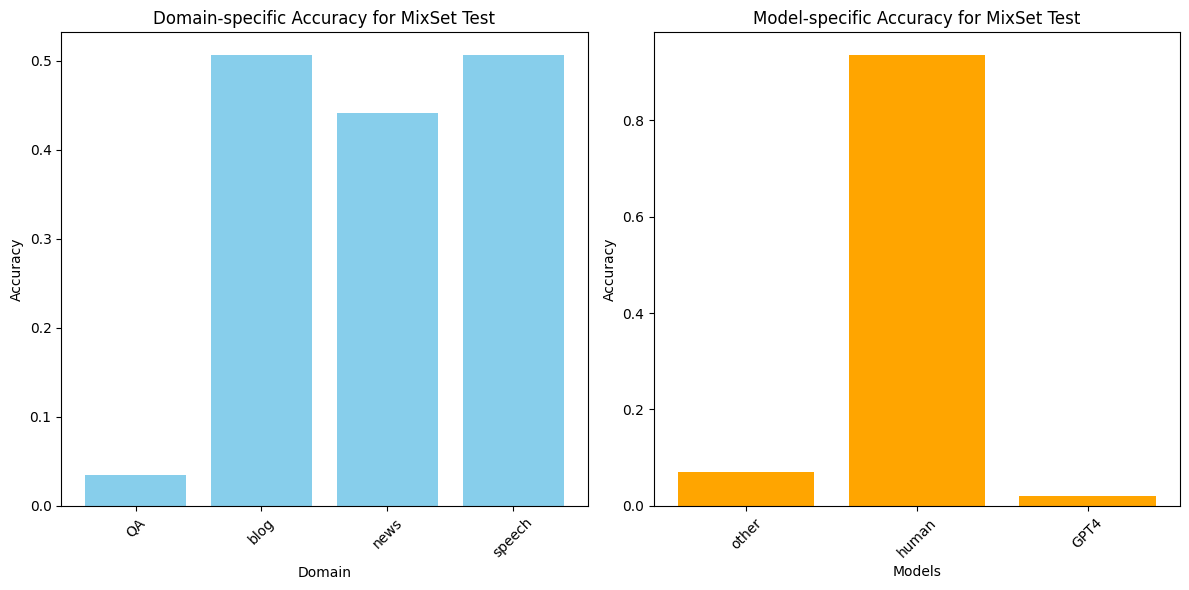

In [31]:
import torch
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
import json

def evaluate_model(model, test_loader, test_data, dataset_name, device='cuda'):
    model.eval()
    all_labels, all_predictions = [], []
    domain_accuracies = {}
    model_accuracies = {}
    dataset_accuracies = {}

    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            outputs = outputs.squeeze(1)  # Squeeze the outputs to remove the extra dimension
            predicted = torch.sigmoid(outputs) > 0.5
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate overall metrics
    test_accuracy = accuracy_score(all_labels, all_predictions)
    test_f1_score = f1_score(all_labels, all_predictions, average='weighted')
    test_precision = precision_score(all_labels, all_predictions, average='weighted')
    test_recall = recall_score(all_labels, all_predictions, average='weighted')
    test_auc = roc_auc_score(all_labels, all_predictions, average='macro', multi_class='ovr')

    # Append domain-specific accuracy
    test_data_with_preds = test_data.assign(predictions=all_predictions)
    for domain in test_data_with_preds['source'].unique():
        domain_specific_data = test_data_with_preds[test_data_with_preds['source'] == domain]
        y_true = domain_specific_data['label'].astype(int).values
        y_pred = domain_specific_data['predictions'].values
        domain_accuracy = accuracy_score(y_true, y_pred)
        domain_accuracies[domain] = domain_accuracy
    
    
    # Only for Mixset only, comment if not evaluating with MixSet
    dataset_labels = {
        'MixsetHUMANIZE': 'Humanize',
        'MixsetCOMPLETE': 'Complete',
        'MixsetREWRITE': 'Rewrite',
        'MixsetPOLISH_SENTENCE': 'Polish'
    }
    mixset_variants = list(dataset_labels.keys())
    for variant in mixset_variants:
        variant_specific_data = test_data_with_preds[(test_data_with_preds['dataset'] == variant) & (test_data_with_preds['model'] == 'GPT4')]
        print(variant_specific_data)
        y_true = variant_specific_data['label'].astype(int).values
        y_pred = variant_specific_data['predictions'].values
        variant_accuracy = accuracy_score(y_true, y_pred)
        dataset_accuracies[dataset_labels[variant]] = variant_accuracy
    
    # Until Here
    
    # Append model-specific accuracy
    for model_type in test_data_with_preds['model'].unique():
        model_specific_data = test_data_with_preds[test_data_with_preds['model'] == model_type]
        y_true = model_specific_data['label'].astype(int).values
        y_pred = model_specific_data['predictions'].values
        model_accuracy = accuracy_score(y_true, y_pred)
        model_accuracies[model_type] = model_accuracy

    print(f"Results for {dataset_name}:")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"F1 Score: {test_f1_score}")
    print(f"Precision: {test_precision}")
    print(f"Recall: {test_recall}")
    print(f"AUC: {test_auc}")
    print("\nDomain-specific Accuracies:")
    for domain, accuracy in domain_accuracies.items():
        print(f"  {domain}: {accuracy:.4f}")
    print("\nModel-specific Accuracies:")
    for model_type, accuracy in model_accuracies.items():
        print(f"  {model_type}: {accuracy:.4f}")
    print("\nDataset-specific Accuracies:")
    for dataset, accuracy in dataset_accuracies.items():
        print(f"   {dataset}: {accuracy:f}")

    # Plotting domain-specific accuracies
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    domains = list(domain_accuracies.keys())
    accuracies = [domain_accuracies[domain] for domain in domains]
    plt.bar(domains, accuracies, color='skyblue')
    plt.xlabel('Domain')
    plt.ylabel('Accuracy')
    plt.title(f'Domain-specific Accuracy for {dataset_name}')
    plt.xticks(rotation=45)

    # Plotting model-specific accuracies
    plt.subplot(122)
    models = list(model_accuracies.keys())
    accuracies = list(model_accuracies.values())
    plt.bar(models, accuracies, color='orange')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title(f'Model-specific Accuracy for {dataset_name}')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig(f'{dataset_name}_accuracies.png')
    plt.show()

    # Save detailed report
    report = {
        'overall_accuracy': test_accuracy,
        'f1_score': test_f1_score,
        'precision': test_precision,
        'recall': test_recall,
        'auc': test_auc,
        'domain_accuracies': domain_accuracies,
        # 'dataset_accuracies': dataset_accuracies # Or just manually copy and paste
        'model_accuracies': model_accuracies,
        'classification_report': classification_report(all_labels, all_predictions, output_dict=True)
    }
    with open(f'{dataset_name}_metrics.json', 'w') as fp:
        json.dump(report, fp, indent=4)

# Use the function to evaluate on different datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
evaluate_model(model, test_loader, test, "General Test", device)
evaluate_model(model, test_loader_MGTBench, test_MGTBench, "MGTBench Test", device)
# Change the setting before doing so
#evaluate_model(model, test_loader_MixSet, test_MixSet, "MixSet Test", device)

Test Accuracy: 0.9398664946429574
F1 Score: 0.9397381712559173
Precision: 0.9432751073593435
Recall: 0.9398664946429574
AUC: 0.9396704212047081

Domain-specific Accuracies:
  wikihow: 0.9372171945701357
  arxiv: 0.9199380165289256
  wikipedia: 0.9141104294478528
  peerread: 0.9868065967016492
  reddit: 0.94482381862879
Accuracy by Model:
  human: 0.9839
  cohere: 0.8705
  chatGPT: 0.9653
  davinci: 0.8427

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      8953
           1       0.98      0.90      0.94      8874

    accuracy                           0.94     17827
   macro avg       0.94      0.94      0.94     17827
weighted avg       0.94      0.94      0.94     17827



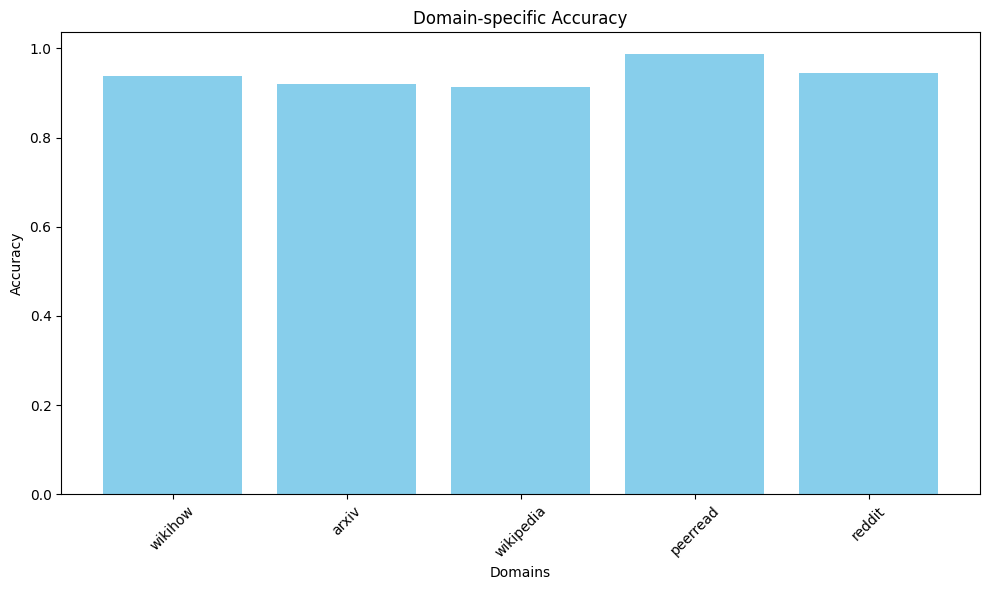

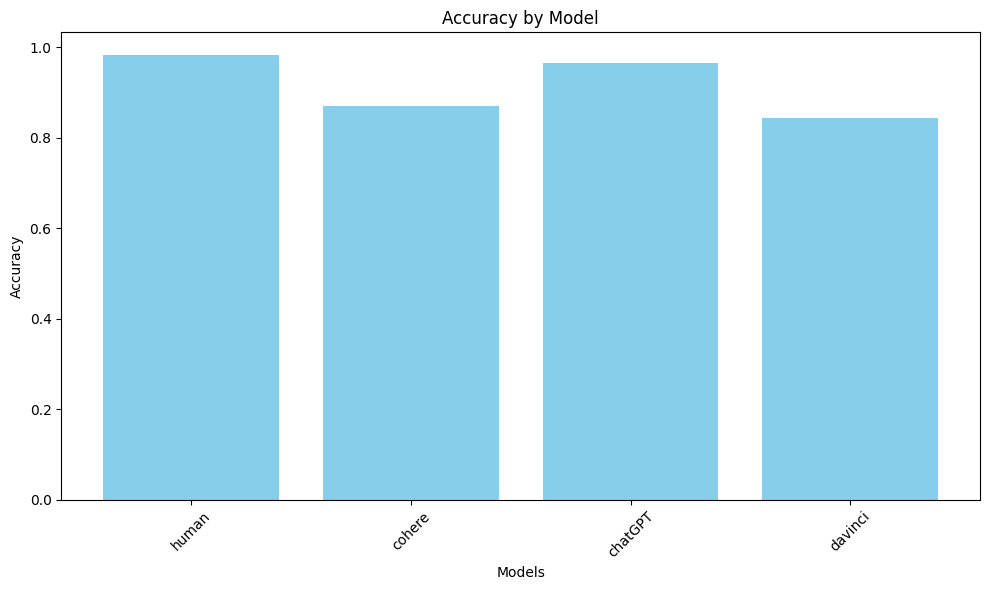

In [30]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import json
import numpy as np
import pandas as pd

# Test the model and collect predictions
model.eval()
all_labels, all_predictions = [], []
domain_accuracies = {}
model_accuracies = {}

with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to('cuda'), labels.to('cuda')
        outputs = model(texts)
        outputs = outputs.squeeze(1)  # Squeeze the outputs to remove the extra dimension
        predicted = torch.sigmoid(outputs) > 0.5
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate overall metrics
test_accuracy = accuracy_score(all_labels, all_predictions)
test_f1_score = f1_score(all_labels, all_predictions, average='weighted')
test_precision = precision_score(all_labels, all_predictions, average='weighted')
test_recall = recall_score(all_labels, all_predictions, average='weighted')
test_auc = roc_auc_score(all_labels, all_predictions, average='macro', multi_class='ovr')

# Append domain-specific accuracy
test_data_with_preds = test.assign(predictions=all_predictions)
for domain in test_data_with_preds['source'].unique():
    domain_specific_data = test_data_with_preds[test_data_with_preds['source'] == domain]
    y_true = domain_specific_data['label'].astype(int).values  # Convert labels to integers
    y_pred = domain_specific_data['predictions'].values
    domain_accuracy = accuracy_score(y_true, y_pred)
    domain_accuracies[domain] = domain_accuracy

for model_type in test['model'].unique():
    model_data = test_data_with_preds[test_data_with_preds['model'] == model_type]
    y_true = model_data['label'].astype(int).values  # Ensure labels are integers
    y_pred = model_data['predictions'].values
    model_accuracies[model_type] = accuracy_score(y_true, y_pred)


print(f"Test Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1_score}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"AUC: {test_auc}")
print("\nDomain-specific Accuracies:")
for domain, accuracy in domain_accuracies.items():
    print(f"  {domain}: {accuracy}")
# Print model-specific accuracies
print("Accuracy by Model:")
for model_type, accuracy in model_accuracies.items():
    print(f"  {model_type}: {accuracy:.4f}")

# Detailed report
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions))

# Plotting domain-specific accuracies
domains = list(domain_accuracies.keys())
accuracies = [domain_accuracies[domain] for domain in domains]

plt.figure(figsize=(10, 6))
plt.bar(domains, accuracies, color='skyblue')
plt.xlabel('Domains')
plt.ylabel('Accuracy')
plt.title('Domain-specific Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to not cut off labels
plt.savefig('domain_accuracies.png')
plt.show()    

# Plotting model-specific accuracies for a visual comparison
plt.figure(figsize=(10, 6))
models = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())
plt.bar(models, accuracies, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy by Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_accuracies.png')
plt.show()


# Combine all metrics into a single dictionary
results = {
    'overall_accuracy': test_accuracy,
    'f1_score': test_f1_score,
    'precision': test_precision,
    'recall': test_recall,
    'auc': test_auc,
    'domain_accuracies': domain_accuracies,
    'model_accuracies': model_accuracies,
    'detailed_report': classification_report(all_labels, all_predictions, output_dict=True)
}

# Save to file
with open('model_metrics.json', 'w') as fp:
    json.dump(results, fp, indent=4)
